In [4]:
import os
import pickle
from datetime import datetime

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

from src.config import cfg
from src.dir import create_dir
from src.seed import seed_everything

seed_everything(cfg.seed)

print(np.array([1, 2, 3]))
print(cfg.seed)
print(cfg.lgb)


[1 2 3]
42
{'params': {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 20, 'max_depth': -1, 'subsample_freq': 0, 'bagging_seed': 0, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, 'early_stopping_rounds': 500, 'log_evaluation_period': 100, 'num_boost_round': 100000}


In [2]:
# demo用のデータフレームを作成
train_df = pl.DataFrame(
    {
        "id": np.random.randint(0, 10, 100),
        "feature1": np.random.rand(100),
        "feature2": np.random.rand(100),
        "target": 2 * np.random.rand(100) + 1,
    }
)

test_df = pl.DataFrame(
    {
        "id": np.random.randint(0, 10, 100),
        "feature1": np.random.rand(100),
        "feature2": np.random.rand(100),
    }
)


In [3]:
# 交差検証の設定
skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

# 訓練データにfold列を追加
train_df = train_df.with_columns(fold=pl.lit(-1))

# データを分割し、各フォールドにインデックスを割り当てる
for fold, (_, val_index) in enumerate(skf.split(train_df, train_df["id"])):
    train_df[val_index, "fold"] = fold

# モデル評価用の変数を初期化
scores_lgb = []
models_lgb = []
feature_importances = []

features = test_df.columns
target = "target"

for fold in range(cfg.n_splits):
    print(f"\nTraining for fold: {fold}...")

    # 訓練データと検証データを分割
    train_data = train_df.filter(pl.col("fold") != fold)
    val_data = train_df.filter(pl.col("fold") == fold)

    # LightGBM用のデータセットを作成
    lgb_train = lgb.Dataset(train_data[features].to_pandas(), train_data[target].to_pandas())
    lgb_val = lgb.Dataset(val_data[features].to_pandas(), val_data[target].to_pandas())

    # コールバック関数の設定
    callbacks = [
        lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
        lgb.log_evaluation(cfg.lgb.log_evaluation_period),
    ]

    # モデルの訓練
    model_lgb = lgb.train(
        dict(cfg.lgb.params),
        lgb_train,
        valid_sets=[lgb_val],
        callbacks=callbacks,
        num_boost_round=100,
    )

    # モデルの保存
    current_time = datetime.now().strftime("%y%m%d_%H%M")
    model_folder = f"lgb_{current_time}"
    model_dir_path = os.path.join(cfg.data.model_path, model_folder)
    create_dir(model_dir_path)

    with open(f"{model_dir_path}/model_fold_{fold}.pkl", "wb") as f:
        pickle.dump(model_lgb, f)

    # ログファイルの作成と保存
    log_content = "LightGBMパラメータ:\n"
    for key, value in cfg.lgb.params.items():
        log_content += f"{key}: {value}\n"
    log_content += "\n使用した特徴量:\n"
    for feature in features:
        log_content += f"{feature}\n"

    with open(f"{model_dir_path}/log.txt", "w") as log_file:
        log_file.write(log_content)

    # 検証データの予測
    val_pred_lgb = model_lgb.predict(val_data[features].to_pandas(), num_iteration=model_lgb.best_iteration)

    # モデルの評価
    score_lgb = np.sqrt(mean_squared_error(val_data[target].to_pandas(), val_pred_lgb))
    scores_lgb.append(score_lgb)

    print(f"RMSE for fold {fold}: {score_lgb}")

    # 特徴量の重要度を保存
    feature_importances.append(model_lgb.feature_importance(importance_type="gain"))

# Calculate the average score
seen_average_score_lgb = np.mean(scores_lgb)

print(f"Average RMSE: {seen_average_score_lgb}")

# Calculate the average feature importance
average_feature_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({"feature": features, "importance": average_feature_importance}).sort_values(
    by="importance", ascending=False
)



Training for fold: 0...
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 0.544757
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.544757
Directory created: ../data/model/lgb_240824_2054
RMSE for fold 0: 0.5447574697371276

Training for fold: 1...
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 0.562295
Did not meet early stopping. Best iteration is:
[44]	valid_0's rmse: 0.558936
Directory already exists: ../data/model/lgb_240824_2054
RMSE for fold 1: 0.5589357019447682

Training for fold: 2...
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 0.616542
Did not meet early stopping. Best iteration is:
[1]	valid_0's rmse: 0.603765
Directory already exists: ../data/model/lgb_240824_2054
RMSE for fold 2: 0.6037645254229985

Training for fold: 3...
Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 0.556587
Did not meet early stoppi

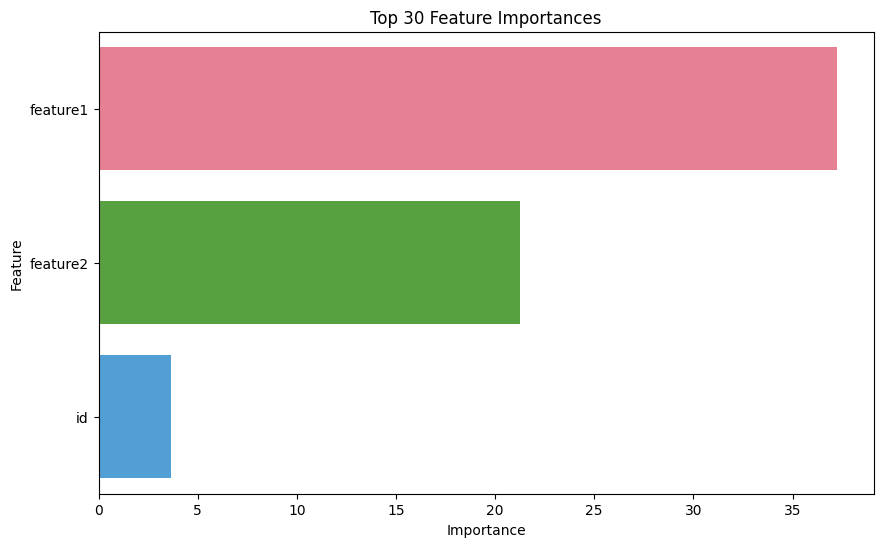

In [8]:
# feature_importanceの上位20個をseabornで可視化する

# 上位20個の特徴量重要度を取得
top_30_features = feature_importance_df.head(30)

# カラフルな色を生成
colors = sns.color_palette("husl", len(top_30_features))

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top_30_features, palette=colors, legend=False, hue="feature")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 30 Feature Importances")
plt.show()
